# Multi Agents - 자율 연구 에이전트 (고급)

## 개요
LangGraph를 활용하여 동적 워크플로우, 루프/재귀, Human-in-the-loop 패턴을 구현하는 자율 연구 시스템을 만듭니다.

## 구성
1. **계획 에이전트**: 연구 주제 분석 및 계획 수립
2. **검색 에이전트**: 정보 수집 및 자료 검색
3. **분석 에이전트**: 수집된 데이터 분석
4. **검증 에이전트**: 정보의 신뢰성과 완성도 검증
5. **조정 에이전트**: 추가 조사 필요 여부 판단 및 워크플로우 제어
6. **보고서 에이전트**: 최종 연구 보고서 작성

## 학습 목표
- 동적 워크플로우 (Dynamic Workflow): 실행 중 경로 변경
- 루프와 재귀 (Loop & Recursion): 조건에 따라 반복 실행
- Human-in-the-loop (HITL): 중요한 결정에 사용자 개입


## 1. 환경 설정 및 라이브러리 임포트


In [1]:
import os
from typing import TypedDict, List, Literal, Annotated
from operator import add
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
import time

### API 키 설정
- [OpenAI API 키](https://platform.openai.com/api-keys)
- [Tavily API 키](https://tavily.com/) - 실제 웹 검색 기능 사용 (선택사항)

In [ ]:
import os

# API 키 설정
os.environ["OPENAI_API_KEY"] = "sk-proj-"
os.environ["TAVILY_API_KEY"] = "tvly-dev-"

# API 키 확인
openai_key = os.getenv("OPENAI_API_KEY")
tavily_key = os.getenv("TAVILY_API_KEY")

if openai_key:
    print("OpenAI API 키가 설정되었습니다. (GPT 모델 사용)")
else:
    print("OpenAI API 키가 없습니다.")

if tavily_key:
    print("Tavily API 키가 설정되었습니다. (웹 검색 사용)")
else:
    print("Tavily API 키가 없습니다. (검색 기능이 시뮬레이션 모드로 작동합니다)")

OpenAI API 키가 설정되었습니다. (GPT 모델 사용)
Tavily API 키가 설정되었습니다. (웹 검색 사용)


### LLM 초기화

In [3]:
# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

### Tavily 검색 도구 초기화 (실제 웹 검색용)

In [4]:
# Tavily 검색 도구 초기화 (실제 웹 검색용)
tavily_search = TavilySearchResults(
    max_results=3,  # 최대 검색 결과 개수
    search_depth="basic",  # 검색 깊이 (basic, advanced)
    include_answer=True,  # 답변 포함 여부
    include_raw_content=False,  # 원본 내용 포함 여부
    include_images=False,  # 이미지 포함 여부
    include_domains=[
        "https://www.naver.com", # 뉴스
        "https://www.github.com", # 개발
        "https://kr.investing.com/equities/south-korea" # 주식
    ]
)

/var/folders/tv/05qbcb8954z9x1yvqv_kr2t80000gn/T/ipykernel_78147/2269374098.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(


## 2. 상태 정의 (State Management)

고급 워크플로우를 위한 복잡한 상태 구조를 정의합니다. 루프 제어, 이력 관리, 검증 상태 등을 포함합니다.


In [5]:
class ResearchState(TypedDict):
    """
    자율 연구 시스템의 상태를 정의하는 클래스
    
    Attributes:
        topic: 연구 주제
        research_plan: 연구 계획
        search_results: 검색 결과 리스트 (누적)
        analysis_results: 분석 결과 리스트 (누적)
        verification_status: 검증 상태 (passed/failed)
        verification_feedback: 검증 피드백
        needs_more_research: 추가 연구 필요 여부
        iteration_count: 반복 횟수 (무한 루프 방지)
        max_iterations: 최대 반복 횟수 (주제 복잡도에 따라 동적 설정)
        human_approval: 사용자 승인 여부
        final_report: 최종 보고서
    """
    topic: str
    research_plan: str
    search_results: Annotated[List[str], add]  # 누적 집계
    analysis_results: Annotated[List[str], add]  # 누적 집계
    verification_status: str
    verification_feedback: str
    needs_more_research: bool
    iteration_count: int
    max_iterations: int  # 동적 최대 반복 횟수
    human_approval: bool
    final_report: str

print("고급 상태 구조가 정의되었습니다.")
print("- 루프 제어: iteration_count, needs_more_research, max_iterations")
print("- 동적 워크플로우: verification_status, verification_feedback")
print("- Human-in-the-loop: human_approval")
print("- 동적 설정: max_iterations (주제 복잡도에 따라 자동 조정)")


고급 상태 구조가 정의되었습니다.
- 루프 제어: iteration_count, needs_more_research, max_iterations
- 동적 워크플로우: verification_status, verification_feedback
- Human-in-the-loop: human_approval
- 동적 설정: max_iterations (주제 복잡도에 따라 자동 조정)


## 3. 에이전트 노드 정의


### 3.1 계획 에이전트


In [6]:
def planning_agent(state: ResearchState) -> dict:
    """
    연구 주제를 분석하고 상세한 연구 계획을 수립하는 에이전트
    주제의 복잡도를 평가하여 최대 반복 횟수를 동적으로 설정
    """
    topic = state["topic"]
    iteration = state.get("iteration_count", 0)
    
    # 첫 번째 반복인 경우 주제 복잡도 평가
    if iteration == 0:
        complexity_messages = [
            SystemMessage(content="""
                당신은 연구 주제 복잡도 평가 전문가입니다.
                주어진 주제의 복잡도를 평가하세요:

                - SIMPLE: 단순하고 명확한 주제 (예: 특정 기술 소개, 단일 개념 설명)
                - MODERATE: 중간 복잡도 주제 (예: 기술 비교, 트렌드 분석)
                - COMPLEX: 복잡한 주제 (예: 다면적 분석, 미래 예측, 철학적 논의)

                반드시 "COMPLEXITY: SIMPLE", "COMPLEXITY: MODERATE", "COMPLEXITY: COMPLEX" 중 하나로 시작하세요."""),
            HumanMessage(content=f"주제: {topic}\n\n이 주제의 복잡도를 평가하세요.")
        ]
        
        complexity_response = llm.invoke(complexity_messages)
        complexity_text = complexity_response.content
        
        # 복잡도에 따른 최대 반복 횟수 설정
        if "COMPLEXITY: SIMPLE" in complexity_text:
            max_iterations = 2
            complexity_level = "단순"
        elif "COMPLEXITY: COMPLEX" in complexity_text:
            max_iterations = 4
            complexity_level = "복잡"
        else:
            max_iterations = 3
            complexity_level = "중간"
        
        print(f"[계획 에이전트] 주제 복잡도: {complexity_level} (최대 {max_iterations}회 반복)")
    else:
        max_iterations = state.get("max_iterations", 3)
    
    # 재연구인 경우 피드백 반영
    feedback = state.get("verification_feedback", "")
    feedback_context = f"\n\n이전 피드백: {feedback}" if feedback else ""
    
    messages = [
        SystemMessage(content="""
            당신은 연구 계획 전문가입니다.
            주어진 주제에 대해 체계적인 연구 계획을 수립하세요:
            1. 핵심 조사 질문 정의
            2. 필요한 정보 유형 파악
            3. 검색 키워드 제안
            4. 분석 방향 제시

            간결하고 실행 가능한 계획을 작성하세요."""),
        HumanMessage(content=f"주제: {topic}{feedback_context}\n\n연구 계획을 수립하세요.")
    ]
    
    response = llm.invoke(messages)
    plan = response.content
    
    print(f"[계획 에이전트] 연구 계획 수립 완료 (반복 {iteration + 1}회 / 최대 {max_iterations}회)")
    
    return {
        "research_plan": plan,
        "iteration_count": iteration + 1,
        "max_iterations": max_iterations
    }


### 3.2 검색 에이전트 (TavilySearchResults 사용)

실제 웹 검색을 수행하는 에이전트입니다. 

**TavilySearchResults 사용:**
- Tavily API 키가 있으면 실제 웹 검색 수행
- Tavily API 키가 없으면 시뮬레이션 모드로 작동
- API 키 발급: [Tavily](https://tavily.com/)

**참고:** Tavily API 키를 설정하려면 위의 API 키 설정 셀에서 주석을 제거하고 키를 입력하세요.


In [7]:
def search_agent(state: ResearchState) -> dict:
    """
    연구 계획에 따라 정보를 검색하고 수집하는 에이전트
    TavilySearchResults를 사용하여 실제 웹 검색 수행
    """
    topic = state["topic"]
    plan = state["research_plan"]
    iteration = state['iteration_count']
    
    # Tavily 검색이 가능한 경우 실제 웹 검색 수행
    if tavily_search is not None:
        try:
            # 검색 쿼리 생성 (주제 + 계획의 핵심 키워드)
            search_query = f"{topic}"
            
            print(f"[검색 에이전트] 웹 검색 실행: {search_query}")
            
            # 실제 웹 검색 수행
            search_results_raw = tavily_search.invoke({"query": search_query})
            
            # 검색 결과를 포맷팅
            formatted_results = []
            for i, result in enumerate(search_results_raw, 1):
                url = result.get('url', 'N/A')
                content = result.get('content', 'N/A')
                formatted_results.append(f"출처 {i}: {url}\n내용: {content}")
            
            search_result_text = "\n\n".join(formatted_results)
            
            # LLM을 사용하여 검색 결과 요약 및 분석
            summary_messages = [
                SystemMessage(content="""당신은 정보 분석 전문가입니다.
웹 검색 결과를 분석하여 연구 주제와 관련된 핵심 정보를 요약하세요.
- 각 출처의 주요 내용 정리
- 관련성 높은 정보 강조
- 상충되는 정보가 있다면 명시"""),
                HumanMessage(content=f"주제: {topic}\n\n검색 결과:\n{search_result_text}\n\n이 결과를 요약하고 분석하세요.")
            ]
            
            summary_response = llm.invoke(summary_messages)
            
            search_result = f"[실제 웹 검색 결과 - 반복 {iteration}]\n\n{summary_response.content}\n\n--- 원본 검색 결과 ---\n{search_result_text[:500]}..."
            
            print(f"[검색 에이전트] 실제 웹 검색 완료 ({len(search_results_raw)}개 결과)")
            
        except Exception as e:
            print(f"[검색 에이전트] 웹 검색 실패: {e}, 시뮬레이션 모드로 전환")
            # 실패 시 시뮬레이션 모드로 대체
            search_result = _simulate_search(topic, plan, iteration)
    else:
        # Tavily가 없는 경우 시뮬레이션 모드
        print(f"[검색 에이전트] 시뮬레이션 모드로 정보 수집")
        search_result = _simulate_search(topic, plan, iteration)
    
    return {
        "search_results": [search_result]
    }

def _simulate_search(topic: str, plan: str, iteration: int) -> str:
    """
    웹 검색을 시뮬레이션하는 헬퍼 함수 (Tavily가 없을 때 사용)
    """
    messages = [
        SystemMessage(content="""당신은 정보 검색 전문가입니다.
연구 계획에 따라 관련 정보를 찾았다고 가정하고, 
실제로 찾을 수 있는 정보의 요약을 제공하세요.

다음 형식으로 작성:
- 출처 1: [주요 내용 요약]
- 출처 2: [주요 내용 요약]
- 출처 3: [주요 내용 요약]"""),
        HumanMessage(content=f"주제: {topic}\n\n계획:\n{plan}\n\n이 계획에 따라 검색한 정보를 요약하세요.")
    ]
    
    response = llm.invoke(messages)
    return f"[시뮬레이션 검색 결과 - 반복 {iteration}]\n{response.content}"


### 3.3 분석 에이전트


In [8]:
def analysis_agent(state: ResearchState) -> dict:
    """
    수집된 정보를 분석하고 인사이트를 도출하는 에이전트
    """
    topic = state["topic"]
    search_results = state["search_results"]
    
    # 최신 검색 결과만 분석 (또는 전체 분석)
    recent_results = "\n\n".join(search_results[-3:])  # 최근 3개
    
    messages = [
        SystemMessage(content="""
            당신은 데이터 분석 전문가입니다.
            수집된 정보를 분석하여:
            1. 핵심 패턴과 트렌드 파악
            2. 주요 발견사항 정리
            3. 상충되는 정보 식별
            4. 추가 조사가 필요한 부분 지적

            분석적이고 비판적인 관점을 유지하세요."""),
        HumanMessage(content=f"주제: {topic}\n\n검색 결과:\n{recent_results}\n\n이 정보를 분석하세요.")
    ]
    
    response = llm.invoke(messages)
    analysis = f"[분석 결과 - 반복 {state['iteration_count']}]\n{response.content}"
    
    print(f"[분석 에이전트] 데이터 분석 완료")
    
    return {
        "analysis_results": [analysis]
    }


### 3.4 검증 에이전트


In [9]:
def verification_agent(state: ResearchState) -> dict:
    """
    정보의 신뢰성과 완성도를 검증하는 에이전트
    """
    topic = state["topic"]
    analysis_results = state["analysis_results"]
    
    # 최신 분석 결과 검토
    recent_analysis = "\n\n".join(analysis_results[-2:])
    
    messages = [
        SystemMessage(content="""
            당신은 연구 품질 검증 전문가입니다.
            분석 결과를 검토하고 다음을 판단하세요:
            1. 정보의 충분성 (충분한가?)
            2. 정보의 신뢰성 (출처가 믿을만한가?)
            3. 논리의 일관성 (모순이 없는가?)
            4. 추가 조사 필요 여부

            반드시 다음 형식으로 시작하세요:
            STATUS: PASSED 또는 STATUS: NEEDS_MORE_RESEARCH

            그 다음 상세한 피드백을 제공하세요."""),
        HumanMessage(content=f"주제: {topic}\n\n분석 결과:\n{recent_analysis}\n\n검증 결과를 제공하세요.")
    ]
    
    response = llm.invoke(messages)
    verification_result = response.content
    
    # 검증 상태 파싱
    if "STATUS: PASSED" in verification_result:
        status = "passed"
        needs_more = False
        print(f"[검증 에이전트] 검증 통과")
    else:
        status = "needs_more_research"
        needs_more = True
        print(f"[검증 에이전트] 추가 조사 필요")
    
    return {
        "verification_status": status,
        "verification_feedback": verification_result,
        "needs_more_research": needs_more
    }


### 3.5 조정 에이전트


In [10]:
def coordination_agent(state: ResearchState) -> dict:
    """
    워크플로우를 제어하고 다음 단계를 결정하는 에이전트
    동적으로 설정된 최대 반복 횟수를 사용
    """
    iteration = state["iteration_count"]
    needs_more = state["needs_more_research"]
    feedback = state["verification_feedback"]
    max_iterations = state.get("max_iterations", 3)  # 동적 최대 반복 횟수
    
    if needs_more and iteration < max_iterations:
        print(f"[조정 에이전트] 추가 조사 필요 - 검색으로 돌아갑니다 (반복 {iteration}/{max_iterations})")
        return {}
    elif iteration >= max_iterations:
        print(f"[조정 에이전트] 최대 반복 횟수 도달 ({max_iterations}회) - 현재 결과로 진행합니다")
        return {
            "needs_more_research": False,
            "verification_status": "max_iterations_reached"
        }
    else:
        print(f"[조정 에이전트] 연구 완료 - 보고서 작성 단계로 진행")
        return {}

#### Human-in-the-loop 노드

In [11]:
# Human-in-the-loop 노드
def human_review_node(state: ResearchState) -> dict:
    """
    사용자의 승인을 받는 노드 (Human-in-the-loop)
    """
    print("\n" + "="*80)
    print("[Human-in-the-loop] 사용자 검토 요청")
    print("="*80)
    print(f"현재 반복: {state['iteration_count']}/{state.get('max_iterations', 3)}")
    print(f"검증 상태: {state['verification_status']}")
    print(f"\n검증 피드백:\n{state['verification_feedback']}")
    print("="*80)
    
    # 실제 구현에서는 input()을 사용하지만, 
    # 자동 테스트를 위해 기본값 제공
    user_input = input("\n계속 진행하시겠습니까? (yes/no, 기본값: yes): ").strip().lower()
    
    if not user_input:
        user_input = "yes"
    
    approval = user_input in ["yes", "y", ""]
    
    if approval:
        print("[Human-in-the-loop] 승인됨 - 계속 진행")
    else:
        print("[Human-in-the-loop] 거부됨 - 워크플로우 중단")
    
    return {
        "human_approval": approval
    }


### 3.6 보고서 에이전트


In [12]:
def report_agent(state: ResearchState) -> dict:
    """
    모든 연구 결과를 종합하여 최종 보고서를 작성하는 에이전트
    """
    topic = state["topic"]
    plan = state["research_plan"]
    all_search = "\n\n".join(state["search_results"])
    all_analysis = "\n\n".join(state["analysis_results"])
    iterations = state["iteration_count"]
    
    messages = [
        SystemMessage(content="""
            당신은 연구 보고서 작성 전문가입니다.
            수집되고 분석된 모든 정보를 종합하여 체계적인 최종 보고서를 작성하세요:

            1. 요약 (Executive Summary)
            2. 연구 배경 및 목적
            3. 주요 발견사항
            4. 상세 분석
            5. 결론 및 제언
            6. 한계점 및 향후 연구 방향

            전문적이고 명확한 보고서를 작성하세요."""),
        HumanMessage(content=f"""
            주제: {topic}

            연구 계획:
            {plan}

            검색 결과:
            {all_search}

            분석 결과:
            {all_analysis}

            (총 {iterations}회 반복 조사 수행)

            위 내용을 바탕으로 최종 보고서를 작성하세요.""")
    ]
    
    response = llm.invoke(messages)
    report = response.content
    
    print(f"[보고서 에이전트] 최종 보고서 작성 완료")
    
    return {
        "final_report": report
    }


## 4. 동적 라우팅 함수

조건에 따라 다음 노드를 동적으로 결정하는 라우팅 함수들을 정의합니다.


In [13]:
def route_after_verification(state: ResearchState) -> Literal["human_review", "coordination"]:
    """
    검증 후 Human-in-the-loop 또는 조정으로 라우팅
    """
    max_iterations = state.get("max_iterations", 3)
    
    # 추가 연구가 필요하거나 최대 반복 도달 시 사람 검토
    needs_review = (
        state["needs_more_research"] or 
        state["iteration_count"] >= max_iterations
    )
    
    if needs_review:
        return "human_review"
    else:
        return "coordination"

In [14]:
def route_after_human_review(state: ResearchState) -> Literal["coordination", "report"]:
    """
    Human review 후 라우팅
    """
    if not state["human_approval"]:
        # 사용자가 거부한 경우 바로 보고서로 (중단)
        return "report"
    else:
        return "coordination"

In [15]:
def route_after_coordination(state: ResearchState) -> Literal["planning", "report"]:
    """
    조정 에이전트 후 루프 또는 종료 결정
    동적으로 설정된 최대 반복 횟수 사용
    """
    max_iterations = state.get("max_iterations", 3)
    
    # 추가 연구가 필요하고 최대 반복 미만이면 루프
    if state["needs_more_research"] and state["iteration_count"] < max_iterations:
        return "planning"  # 루프: 계획으로 돌아감
    else:
        return "report"  # 종료: 보고서 작성


## 5. 그래프 구성 (동적 워크플로우 + 루프)

복잡한 워크플로우를 구성합니다. 조건에 따라 경로가 변경되고, 필요시 루프를 돕니다.

### 그래프 구조
```
시작
  |
  v
계획 <----------+
  |             |
  v             |
검색            | (루프)
  |             |
  v             |
분석            |
  |             |
  v             |
검증            |
  |             |
  v             |
Human Review?   |
  |             |
  v             |
조정 -----------+
  |
  v
보고서
  |
  v
종료
```


In [16]:
# StateGraph 생성
workflow = StateGraph(ResearchState)

# 노드 추가
workflow.add_node("planning", planning_agent)
workflow.add_node("search", search_agent)
workflow.add_node("analysis", analysis_agent)
workflow.add_node("verification", verification_agent)
workflow.add_node("human_review", human_review_node)
workflow.add_node("coordination", coordination_agent)
workflow.add_node("report", report_agent)

# 시작점 설정
workflow.set_entry_point("planning")

# 순차적 연결 (계획 -> 검색 -> 분석 -> 검증)
workflow.add_edge("planning", "search")
workflow.add_edge("search", "analysis")
workflow.add_edge("analysis", "verification")

# 검증 후 조건부 라우팅 (Human review 필요 여부)
workflow.add_conditional_edges(
    "verification",
    route_after_verification,
    {
        "human_review": "human_review",
        "coordination": "coordination"
    }
)

# Human review 후 라우팅
workflow.add_conditional_edges(
    "human_review",
    route_after_human_review,
    {
        "coordination": "coordination",
        "report": "report"
    }
)

# 조정 후 조건부 라우팅 (루프 또는 종료)
workflow.add_conditional_edges(
    "coordination",
    route_after_coordination,
    {
        "planning": "planning",  # 루프: 다시 계획으로
        "report": "report"       # 종료: 보고서로
    }
)

# 보고서에서 종료
workflow.add_edge("report", END)

# 그래프 컴파일
app = workflow.compile()

print("동적 워크플로우 그래프가 성공적으로 구성되었습니다!")
print("- 루프 구조: 조정 -> 계획 (필요시 반복)")
print("- Human-in-the-loop: 검증 -> 사용자 검토")
print("- 동적 라우팅: 상태에 따라 경로 변경")


동적 워크플로우 그래프가 성공적으로 구성되었습니다!
- 루프 구조: 조정 -> 계획 (필요시 반복)
- Human-in-the-loop: 검증 -> 사용자 검토
- 동적 라우팅: 상태에 따라 경로 변경


## 6. 그래프 시각화 (선택사항)


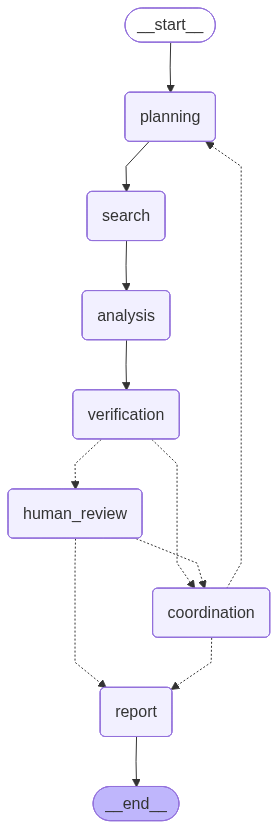

In [17]:
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"그래프 시각화를 위해서는 graphviz가 필요합니다: {e}")
    print("텍스트로 그래프 구조를 확인하세요:")
    print(app.get_graph())


## 7. 테스트 예제

자율 연구 시스템을 실행해봅니다.


### 7.1 연구 주제 설정


In [18]:
research_topic = "LangGraph를 활용한 Multi-Agent 시스템의 장단점과 실제 활용 사례"

print(f"연구 주제: {research_topic}")


연구 주제: LangGraph를 활용한 Multi-Agent 시스템의 장단점과 실제 활용 사례


### 7.2 자율 연구 실행

주의: Human-in-the-loop 단계에서 사용자 입력이 필요합니다.


In [22]:
print("=" * 80)
print("자율 연구 시스템 시작")
print("=" * 80)

# 초기 상태
initial_state = {
    "topic": research_topic,
    "research_plan": "",
    "search_results": [],
    "analysis_results": [],
    "verification_status": "",
    "verification_feedback": "",
    "needs_more_research": False,
    "iteration_count": 0,
    "max_iterations": 3,  # 기본값 (계획 에이전트에서 동적으로 조정됨)
    "human_approval": True,
    "final_report": ""
}

# 그래프 실행
# 주의: input()이 호출되므로 실제 실행 시 사용자 입력 필요
result = app.invoke(initial_state)

print("\n" + "=" * 80)
print("연구 완료!")
print("=" * 80)


자율 연구 시스템 시작
[계획 에이전트] 주제 복잡도: 복잡 (최대 4회 반복)
[계획 에이전트] 연구 계획 수립 완료 (반복 1회 / 최대 4회)
[검색 에이전트] 웹 검색 실행: LangGraph를 활용한 Multi-Agent 시스템의 장단점과 실제 활용 사례
[검색 에이전트] 실제 웹 검색 완료 (3개 결과)
[분석 에이전트] 데이터 분석 완료
[검증 에이전트] 추가 조사 필요

[Human-in-the-loop] 사용자 검토 요청
현재 반복: 1/4
검증 상태: needs_more_research

검증 피드백:
STATUS: NEEDS_MORE_RESEARCH

상세 피드백:

1. **정보의 충분성**: 분석 결과는 LangGraph와 crewAI의 장단점 및 실제 활용 사례에 대한 기본적인 이해를 제공하지만, 두 시스템 간의 직접적인 비교가 부족하여 정보의 깊이가 떨어진다. 또한, 각 시스템의 강점과 약점에 대한 구체적인 데이터나 사례가 부족하다.

2. **정보의 신뢰성**: 제공된 정보는 관련된 기술과 시스템에 대한 일반적인 이해를 바탕으로 하고 있으나, 구체적인 출처나 데이터가 부족하여 신뢰성을 평가하기 어렵다. 따라서 정보의 출처를 명확히 하고, 신뢰할 수 있는 자료를 인용하는 것이 필요하다.

3. **논리의 일관성**: 분석 결과는 전반적으로 일관성을 유지하고 있지만, LangGraph와 crewAI의 차별점에 대한 명확한 설명이 부족하여, 두 시스템의 상대적 장단점에 대해 명확한 결론을 내리기 어렵다.

4. **추가 조사 필요 여부**: LangGraph와 crewAI의 직접적인 비교, 실제 사례를 통한 심층 분석, 그리고 crewAI의 비즈니스 자동화 성공 사례 및 한계에 대한 추가 연구가 필요하다. 이러한 조사를 통해 더 명확하고 구체적인 결론을 도출할 수 있을 것이다.

결론적으로, 현재 제공된 정보는 기초적인 이해를 제공하지만, 보다 심층적이고 구체적인 분석이 필요한 상황이다.
[Human-in-the-loop] 승인됨 - 계

### 7.3 최종 보고서 확인


In [23]:
print("\n" + "=" * 80)
print("최종 연구 보고서")
print("=" * 80)
print(f"\n총 반복 횟수: {result['iteration_count']}")
print(f"검증 상태: {result['verification_status']}")
print("\n" + "-" * 80)
print(result["final_report"])
print("-" * 80)



최종 연구 보고서

총 반복 횟수: 2
검증 상태: needs_more_research

--------------------------------------------------------------------------------
# LangGraph를 활용한 Multi-Agent 시스템의 장단점과 실제 활용 사례

## 1. 요약 (Executive Summary)
본 보고서는 LangGraph와 crewAI를 활용한 Multi-Agent 시스템의 장단점 및 실제 활용 사례를 분석하고, 두 시스템 간의 비교를 통해 각 기술의 강점과 약점을 도출하고자 한다. LangGraph는 복잡한 에이전트 로직을 지원하여 시스템의 효율성을 높이는 데 기여하고 있으며, crewAI는 비즈니스 자동화를 위한 오픈소스 솔루션으로 데이터 시각화와 통합하여 실용성을 증대시킨다. 최종적으로, 각 시스템의 적용 가능성과 향후 연구 방향을 제시한다.

## 2. 연구 배경 및 목적
Multi-Agent 시스템은 여러 에이전트가 협력하여 문제를 해결하는 시스템으로, 최근 인공지능과 데이터 분석 기술의 발전에 따라 그 중요성이 더욱 커지고 있다. LangGraph와 crewAI는 각각의 독특한 접근 방식을 통해 Multi-Agent 시스템의 효율성을 극대화하고자 하며, 본 연구는 이들 시스템의 기술적 차별성을 분석하고 실제 활용 사례를 통해 이론적 지식의 실용성을 향상시키는 것을 목적으로 한다.

## 3. 주요 발견사항
1. **LangGraph의 장점**: 복잡한 에이전트 로직을 지원하는 구조적 장점으로 Multi-Agent 시스템의 효율성을 높인다.
2. **crewAI의 활용**: 비즈니스 자동화 및 데이터 시각화의 통합을 통해 실용성을 증대시키며, 클라우드 서비스와의 협업으로 데이터 처리 효율성을 높인다.
3. **실제 경험의 중요성**: 이론적 지식보다 실제 프로젝트에서의 시행착오와 문제 해결 경험이 Multi-Agent 시스템의 발전에 기여한다.

## 4. 상세 분석
#

### 7.4 연구 과정 추적


In [24]:
print("\n" + "=" * 80)
print("연구 과정 추적")
print("=" * 80)

print(f"\n[검색 결과 수집]: {len(result['search_results'])}회")
for i, search in enumerate(result['search_results'], 1):
    print(f"\n--- 검색 {i} ---")
    print(search[:200] + "..." if len(search) > 200 else search)

print(f"\n\n[분석 수행]: {len(result['analysis_results'])}회")
for i, analysis in enumerate(result['analysis_results'], 1):
    print(f"\n--- 분석 {i} ---")
    print(analysis[:200] + "..." if len(analysis) > 200 else analysis)



연구 과정 추적

[검색 결과 수집]: 2회

--- 검색 1 ---
[실제 웹 검색 결과 - 반복 1]

### LangGraph를 활용한 Multi-Agent 시스템의 장단점과 실제 활용 사례

#### 출처 1: [Naver Blog - LangGraph의 활용](https://blog.naver.com/fstory97/223862431036?fromRss=true&trackingCode=rss)
- **주요 내용**:...

--- 검색 2 ---
[실제 웹 검색 결과 - 반복 2]

### LangGraph를 활용한 Multi-Agent 시스템의 장단점과 실제 활용 사례

#### 출처 1: Naver Blog (https://blog.naver.com/fstory97/223862431036?fromRss=true&trackingCode=rss)
- **주요 내용**: LangGraph는 순환 그래...


[분석 수행]: 2회

--- 분석 1 ---
[분석 결과 - 반복 1]
### 1. 핵심 패턴과 트렌드 파악
- **LangGraph의 구조적 장점**: LangGraph가 제공하는 순환 그래프 구조는 복잡한 Multi-Agent 시스템의 로직 구현에 필수적이며, 이는 시스템의 훈련과 배포를 현실적으로 가능하게 하는 데 중요한 역할을 한다.
- **비즈니스 자동화와 데이터 시각화**: crewAI를 ...

--- 분석 2 ---
[분석 결과 - 반복 2]
### 1. 핵심 패턴과 트렌드 파악
- **LangGraph의 구조적 장점**: LangGraph는 순환 그래프 구조를 지원하여 복잡한 에이전트 실행 로직을 구현하는 데 용이함. 이는 Multi-Agent 시스템의 효율성을 높이는 데 중요한 역할을 함.
- **비즈니스 자동화의 증가**: crewAI와 같은 오픈소스 라이브러리를...
